In [3]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

In [4]:
#installing geopy
#conda install -c conda-forge geopy --y

Let's use BeautifulSoup to scrape the table from Wikipedia and turn it into a dataframe with three columns named PostalCode, Borough, and Neighborhood.

In [5]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
r = requests.get(url)
html = r.text
soup = BeautifulSoup(html)
table = soup.find('table', {"class": "wikitable sortable"})
rows = table.find_all('tr')
data = []
for row in rows[1:]:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    data.append([ele for ele in cols if ele])

df = pd.DataFrame(data, columns=['PostalCode', 'Borough', 'Neighborhood'])
df.head(10)

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor
7,M7A,Downtown Toronto,Queen's Park
8,M8A,Not assigned,Not assigned
9,M9A,Queen's Park,Not assigned


Let's filter out all rows with a borough that is not assigned

In [6]:
df.drop(df.index[df['Borough'] == "Not assigned"], inplace = True)

Let's merge rows with the same postal code by using the groupby function. To avoid having duplicate values for borough (i.e. ScarboroughScarborough), we aggregate this column by 'first'. We want to join and separate neighborhoods by commas, so we use .join with ', '. We also need to reset row indices and reindex everything.


In [7]:
newdf=(df.groupby('PostalCode')
   .agg({'Borough' : 'first', 'Neighborhood' : ', '.join})
   .reset_index()
   .reindex(columns=df.columns))
newdf.tail(10)

,PostalCode,Borough,Neighborhood
93,M9A,Queen's Park,Not assigned
94,M9B,Etobicoke,"Cloverdale, Islington, Martin Grove, Princess ..."
95,M9C,Etobicoke,"Bloordale Gardens, Eringate, Markland Wood, Ol..."
96,M9L,North York,Humber Summit
97,M9M,North York,"Emery, Humberlea"
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Kingsview Village, Martin Grove Gardens, Richv..."
101,M9V,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ..."
102,M9W,Etobicoke,Northwest


Now, let's change the values of 'not assigned' neighborhoods to the name of their borough

In [8]:
newdf['Neighborhood'] = np.where(newdf['Neighborhood'] == "Not assigned", newdf['Borough'], newdf['Neighborhood'])
newdf.tail(10)

,PostalCode,Borough,Neighborhood
93,M9A,Queen's Park,Queen's Park
94,M9B,Etobicoke,"Cloverdale, Islington, Martin Grove, Princess ..."
95,M9C,Etobicoke,"Bloordale Gardens, Eringate, Markland Wood, Ol..."
96,M9L,North York,Humber Summit
97,M9M,North York,"Emery, Humberlea"
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Kingsview Village, Martin Grove Gardens, Richv..."
101,M9V,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ..."
102,M9W,Etobicoke,Northwest


Finally, let's print the number of rows/columns of the dataframe:

In [9]:
newdf.shape

(103, 3)

---

# *Geospatial Data*

I downloaded the Geospatial_Coordinates.csv and read it to a dataframe I named geodf

In [10]:
geodf = pd.read_csv ("/Users/draganastajic/Downloads/Geospatial_Coordinates.csv")

To make merging of the dataframes easier, we can rename the Postal Code column in geodf

In [11]:
geodf.rename(columns={'Postal Code':'PostalCode'}, inplace=True)
geodf.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Now that we have a column with the same name in both datasets, we can merge them, which will add latitude and longitude columns to newdf rows that have matching PostalCode values with geodf

In [12]:
merged = pd.merge(left=newdf,right=geodf)
merged.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


In [13]:
merged.loc[merged["Borough"]=="Etobicoke"]

,PostalCode,Borough,Neighborhood,Latitude,Longitude
88,M8V,Etobicoke,"Humber Bay Shores, Mimico South, New Toronto",43.605647,-79.501321
89,M8W,Etobicoke,"Alderwood, Long Branch",43.602414,-79.543484
90,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
91,M8Y,Etobicoke,"Humber Bay, King's Mill Park, Kingsway Park So...",43.636258,-79.498509
92,M8Z,Etobicoke,"Kingsway Park South West, Mimico NW, The Queen...",43.628841,-79.520999
94,M9B,Etobicoke,"Cloverdale, Islington, Martin Grove, Princess ...",43.650943,-79.554724
95,M9C,Etobicoke,"Bloordale Gardens, Eringate, Markland Wood, Ol...",43.643515,-79.577201
99,M9P,Etobicoke,Westmount,43.696319,-79.532242
100,M9R,Etobicoke,"Kingsview Village, Martin Grove Gardens, Richv...",43.688905,-79.554724
101,M9V,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ...",43.739416,-79.588437


In [14]:
merged.shape

(103, 5)

---

# *Folium Map*

Let's create a map of Toronto with markers based on our data

In [15]:
import folium
latitude = 43.6532
longitude = -79.3832
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(merged['Latitude'], merged['Longitude'], merged['Borough'], merged['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

According to our problem, we are going to observe only the Etobicoke borough

In [16]:
toronto_data = merged[merged['Borough'] == 'Etobicoke'].reset_index(drop=True)
toronto_data.head()
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Foursquare credentials

In [17]:
CLIENT_ID = 'NELQTOMDEJOL2U0H201N2PHYOCHOGEEJCYK4HPLO40IU0OQ2' # your Foursquare ID
CLIENT_SECRET = 'GEBUF2CMEDMZTXJWWPQA442Y5LPBXQDPAMQ2PLZ0HAHVEJKJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100
radius = 500

print('My credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentials:
CLIENT_ID: NELQTOMDEJOL2U0H201N2PHYOCHOGEEJCYK4HPLO40IU0OQ2
CLIENT_SECRET:GEBUF2CMEDMZTXJWWPQA442Y5LPBXQDPAMQ2PLZ0HAHVEJKJ


In [25]:
url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION,  
    43.6205,
    -79.513199,
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/search?&client_id=NELQTOMDEJOL2U0H201N2PHYOCHOGEEJCYK4HPLO40IU0OQ2&client_secret=GEBUF2CMEDMZTXJWWPQA442Y5LPBXQDPAMQ2PLZ0HAHVEJKJ&v=20180605&ll=43.6205,-79.513199&radius=500&limit=100'

In [26]:
import io
from pandas.io.json import json_normalize

In [27]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [28]:
import requests
results = requests.get(url).json()
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(50)

KeyError: 'groups'

In [29]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'], 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [30]:
etobicoke_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

Humber Bay Shores, Mimico South, New Toronto
Alderwood, Long Branch
The Kingsway, Montgomery Road, Old Mill North
Humber Bay, King's Mill Park, Kingsway Park South East, Mimico NE, Old Mill South, The Queensway East, Royal York South East, Sunnylea
Kingsway Park South West, Mimico NW, The Queensway West, Royal York South West, South of Bloor
Cloverdale, Islington, Martin Grove, Princess Gardens, West Deane Park
Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe
Westmount
Kingsview Village, Martin Grove Gardens, Richview Gardens, St. Phillips
Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown
Northwest


In [31]:
print(etobicoke_venues.shape)
etobicoke_venues.head(60)

(69, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Humber Bay Shores, Mimico South, New Toronto",43.605647,-79.501321,LCBO,43.602281,-79.499302,Liquor Store
1,"Humber Bay Shores, Mimico South, New Toronto",43.605647,-79.501321,New Toronto Fish & Chips,43.601849,-79.503281,Restaurant
2,"Humber Bay Shores, Mimico South, New Toronto",43.605647,-79.501321,Domino's Pizza,43.601583,-79.500905,Pizza Place
3,"Humber Bay Shores, Mimico South, New Toronto",43.605647,-79.501321,Delicia Bakery & Pastry,43.601403,-79.503012,Bakery
4,"Humber Bay Shores, Mimico South, New Toronto",43.605647,-79.501321,Lucky Dice Restaurant,43.601392,-79.503056,Café
5,"Humber Bay Shores, Mimico South, New Toronto",43.605647,-79.501321,Popeyes Louisiana Kitchen,43.602069,-79.499400,Fried Chicken Joint
6,"Humber Bay Shores, Mimico South, New Toronto",43.605647,-79.501321,McDonald's,43.602464,-79.498859,Fast Food Restaurant
7,"Humber Bay Shores, Mimico South, New Toronto",43.605647,-79.501321,Shoppers Drug Mart,43.601677,-79.502239,Pharmacy
8,"Humber Bay Shores, Mimico South, New Toronto",43.605647,-79.501321,Sense Appeal,43.601729,-79.501063,Café
9,"Humber Bay Shores, Mimico South, New Toronto",43.605647,-79.501321,Crossfit Colosseum,43.604816,-79.507024,Gym


In [32]:
etobicoke_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",9,9,9,9,9,9
"Alderwood, Long Branch",9,9,9,9,9,9
"Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe",7,7,7,7,7,7
"Humber Bay Shores, Mimico South, New Toronto",13,13,13,13,13,13
"Humber Bay, King's Mill Park, Kingsway Park South East, Mimico NE, Old Mill South, The Queensway East, Royal York South East, Sunnylea",1,1,1,1,1,1
"Kingsview Village, Martin Grove Gardens, Richview Gardens, St. Phillips",4,4,4,4,4,4
"Kingsway Park South West, Mimico NW, The Queensway West, Royal York South West, South of Bloor",14,14,14,14,14,14
Northwest,2,2,2,2,2,2
"The Kingsway, Montgomery Road, Old Mill North",2,2,2,2,2,2


In [33]:
print('There are {} uniques categories.'.format(len(etobicoke_venues['Venue Category'].unique())))

There are 38 uniques categories.


In [34]:
etobicoke_venues['Venue Category'].value_counts()

Pizza Place                  8
Coffee Shop                  5
Sandwich Place               5
Gym                          3
Fast Food Restaurant         3
Café                         3
Pharmacy                     3
Grocery Store                3
Liquor Store                 2
Discount Store               2
Convenience Store            2
Bakery                       2
Fried Chicken Joint          2
Beer Store                   2
Cosmetics Shop               1
Hardware Store               1
Drugstore                    1
Baseball Field               1
Park                         1
Mobile Phone Shop            1
Supplement Shop              1
Tanning Salon                1
Intersection                 1
Chinese Restaurant           1
Mexican Restaurant           1
Restaurant                   1
Middle Eastern Restaurant    1
Skating Rink                 1
Bus Line                     1
Burrito Place                1
Wings Joint                  1
River                        1
Pub     

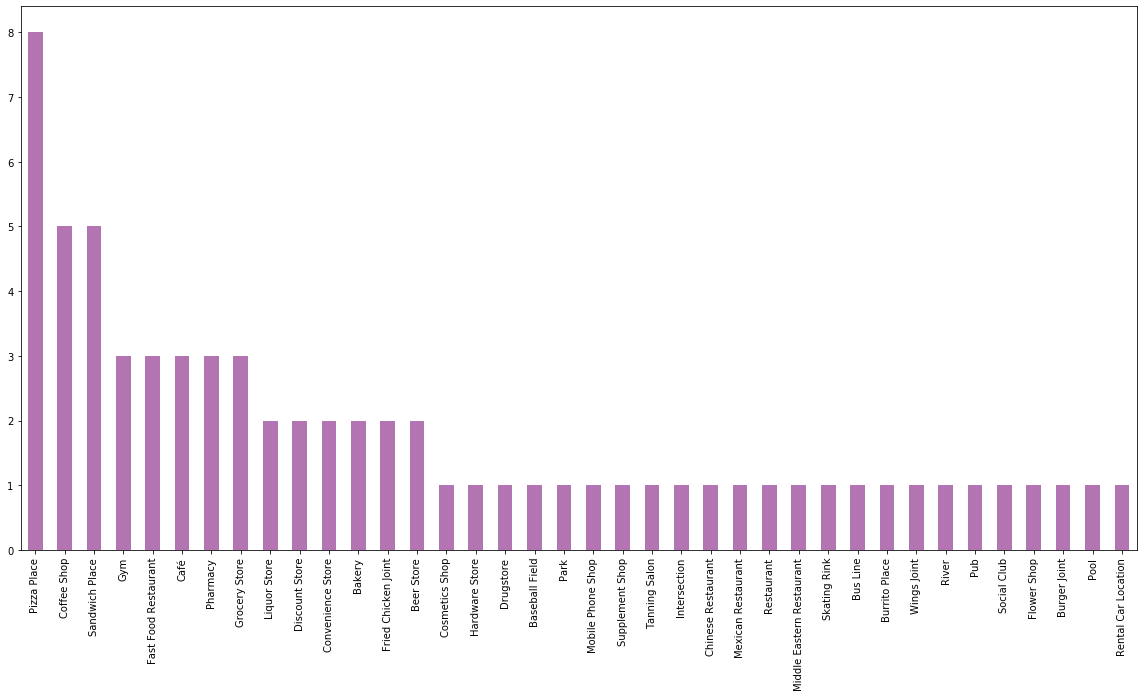

In [36]:
etobicoke_venues['Venue Category'].value_counts().plot.bar(figsize=[20,10], color = (0.5,0.1,0.5,0.6) )

In [41]:
etobicoke_venues=etobicoke_venues[etobicoke_venues['Venue Category'].str.contains("Restaurant|Joint|Place")]

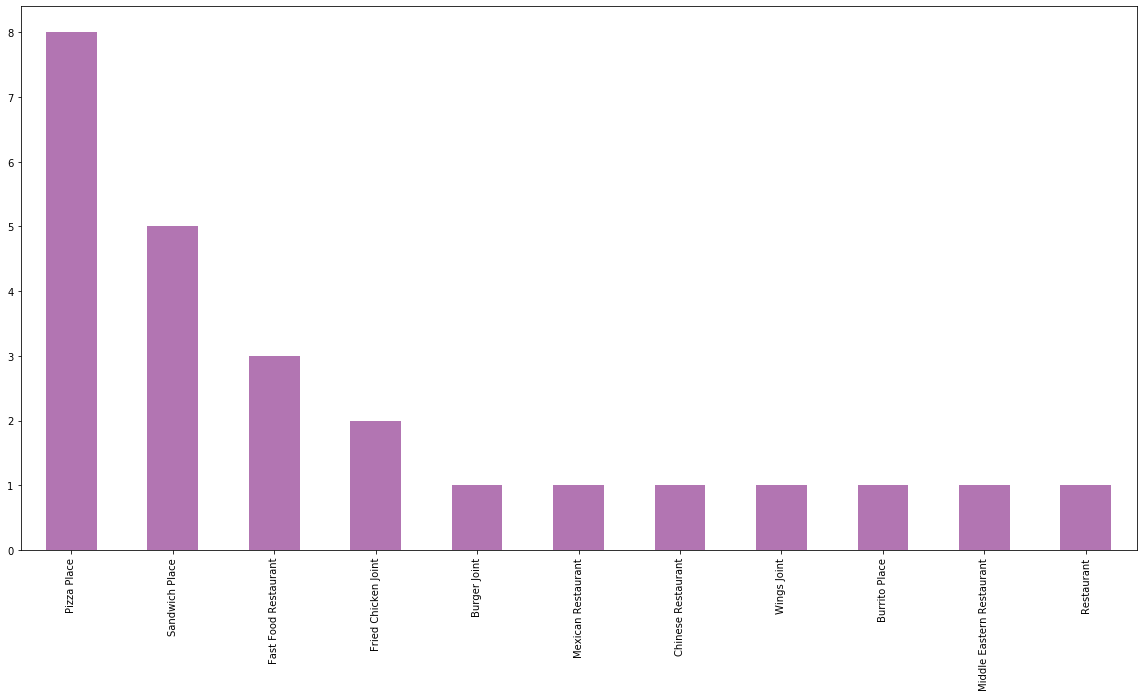

In [42]:
etobicoke_venues['Venue Category'].value_counts().plot.bar(figsize=[20,10], color = (0.5,0.1,0.5,0.6) )

Analyze each neighborhood:

In [43]:
# one hot encoding
etobicoke_onehot = pd.get_dummies(etobicoke_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
etobicoke_onehot['Neighborhood'] = etobicoke_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [etobicoke_onehot.columns[-1]] + list(etobicoke_onehot.columns[:-1])
etobicoke_onehot = etobicoke_onehot[fixed_columns]

etobicoke_onehot.head()

,Neighborhood,Burger Joint,Burrito Place,Chinese Restaurant,Fast Food Restaurant,Fried Chicken Joint,Mexican Restaurant,Middle Eastern Restaurant,Pizza Place,Restaurant,Sandwich Place,Wings Joint
1,"Humber Bay Shores, Mimico South, New Toronto",0,0,0,0,0,0,0,0,1,0,0
2,"Humber Bay Shores, Mimico South, New Toronto",0,0,0,0,0,0,0,1,0,0,0
5,"Humber Bay Shores, Mimico South, New Toronto",0,0,0,0,1,0,0,0,0,0,0
6,"Humber Bay Shores, Mimico South, New Toronto",0,0,0,1,0,0,0,0,0,0,0
12,"Humber Bay Shores, Mimico South, New Toronto",0,0,0,0,0,1,0,0,0,0,0


In [44]:
etobicoke_onehot.shape

(25, 12)

In [45]:
etobicoke_grouped = etobicoke_onehot.groupby('Neighborhood').mean().reset_index()
etobicoke_grouped

,Neighborhood,Burger Joint,Burrito Place,Chinese Restaurant,Fast Food Restaurant,Fried Chicken Joint,Mexican Restaurant,Middle Eastern Restaurant,Pizza Place,Restaurant,Sandwich Place,Wings Joint
0,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.0,0.0,0.0,0.25,0.25,0.0,0.0,0.250000,0.0,0.250000,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.666667,0.0,0.333333,0.0
2,"Bloordale Gardens, Eringate, Markland Wood, Ol...",0.0,0.0,0.0,0.00,0.00,0.0,0.0,1.000000,0.0,0.000000,0.0
3,"Humber Bay Shores, Mimico South, New Toronto",0.0,0.0,0.0,0.20,0.20,0.2,0.0,0.200000,0.2,0.000000,0.0
4,"Kingsview Village, Martin Grove Gardens, Richv...",0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.500000,0.0,0.500000,0.0
5,"Kingsway Park South West, Mimico NW, The Queen...",0.2,0.2,0.0,0.20,0.00,0.0,0.0,0.000000,0.0,0.200000,0.2
6,Westmount,0.0,0.0,0.2,0.00,0.00,0.0,0.2,0.400000,0.0,0.200000,0.0


In [46]:
etobicoke_grouped.shape

(7, 12)

In [47]:
num_top_venues = 20

for hood in etobicoke_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = etobicoke_grouped[etobicoke_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown----
                        venue  freq
0        Fast Food Restaurant  0.25
1         Fried Chicken Joint  0.25
2                 Pizza Place  0.25
3              Sandwich Place  0.25
4                Burger Joint  0.00
5               Burrito Place  0.00
6          Chinese Restaurant  0.00
7          Mexican Restaurant  0.00
8   Middle Eastern Restaurant  0.00
9                  Restaurant  0.00
10                Wings Joint  0.00


----Alderwood, Long Branch----
                        venue  freq
0                 Pizza Place  0.67
1              Sandwich Place  0.33
2                Burger Joint  0.00
3               Burrito Place  0.00
4          Chinese Restaurant  0.00
5        Fast Food Restaurant  0.00
6         Fried Chicken Joint  0.00
7          Mexican Restaurant  0.00
8   Middle Eastern Restaurant  0.00
9                  Restaurant  0.00
10                Win

In [48]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [50]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
merged_venues_sorted = pd.DataFrame(columns=columns)
merged_venues_sorted['Neighborhood'] = etobicoke_grouped['Neighborhood']

for ind in np.arange(etobicoke_grouped.shape[0]):
    merged_venues_sorted.iloc[ind, 1:] = return_most_common_venues(etobicoke_grouped.iloc[ind, :], num_top_venues)

merged_venues_sorted.head(20)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Albion Gardens, Beaumond Heights, Humbergate, ...",Sandwich Place,Pizza Place,Fried Chicken Joint,Fast Food Restaurant,Wings Joint,Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Chinese Restaurant,Burrito Place
1,"Alderwood, Long Branch",Pizza Place,Sandwich Place,Wings Joint,Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Fried Chicken Joint,Fast Food Restaurant,Chinese Restaurant,Burrito Place
2,"Bloordale Gardens, Eringate, Markland Wood, Ol...",Pizza Place,Wings Joint,Sandwich Place,Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Fried Chicken Joint,Fast Food Restaurant,Chinese Restaurant,Burrito Place
3,"Humber Bay Shores, Mimico South, New Toronto",Restaurant,Pizza Place,Mexican Restaurant,Fried Chicken Joint,Fast Food Restaurant,Wings Joint,Sandwich Place,Middle Eastern Restaurant,Chinese Restaurant,Burrito Place
4,"Kingsview Village, Martin Grove Gardens, Richv...",Sandwich Place,Pizza Place,Wings Joint,Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Fried Chicken Joint,Fast Food Restaurant,Chinese Restaurant,Burrito Place
5,"Kingsway Park South West, Mimico NW, The Queen...",Wings Joint,Sandwich Place,Fast Food Restaurant,Burrito Place,Burger Joint,Restaurant,Pizza Place,Middle Eastern Restaurant,Mexican Restaurant,Fried Chicken Joint
6,Westmount,Pizza Place,Sandwich Place,Middle Eastern Restaurant,Chinese Restaurant,Wings Joint,Restaurant,Mexican Restaurant,Fried Chicken Joint,Fast Food Restaurant,Burrito Place


# K-means clustering of Etobicoke neighborhoods

In [74]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 5

etobicoke_grouped_clustering = etobicoke_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(etobicoke_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 0, 2, 1, 0, 3, 0], dtype=int32)

In [75]:
# add clustering labels
merged_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

etobicoke_merged = toronto_data

# merge etobicoke_grouped with etobicoke_data to add latitude/longitude for each neighborhood
etobicoke_merged = etobicoke_merged.join(merged_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

etobicoke_merged.head(10) 

ValueError: cannot insert Cluster Labels, already exists

In [76]:
# create map
import matplotlib.cm as cm
import matplotlib.colors as colors
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(etobicoke_merged['Latitude'], etobicoke_merged['Longitude'], etobicoke_merged['Neighborhood'], etobicoke_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
       
        fill=True,
        fill_color=rainbow,
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Examine clusters

In [77]:
etobicoke_merged.loc[etobicoke_merged['Cluster Labels'] == 0, etobicoke_merged.columns[[2] + list(range(5, etobicoke_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Alderwood, Long Branch",0.0,Pizza Place,Sandwich Place,Wings Joint,Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Fried Chicken Joint,Fast Food Restaurant,Chinese Restaurant,Burrito Place
8,"Kingsview Village, Martin Grove Gardens, Richv...",0.0,Sandwich Place,Pizza Place,Wings Joint,Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Fried Chicken Joint,Fast Food Restaurant,Chinese Restaurant,Burrito Place


In [78]:
etobicoke_merged.loc[etobicoke_merged['Cluster Labels'] == 1, etobicoke_merged.columns[[2] + list(range(5, etobicoke_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Humber Bay Shores, Mimico South, New Toronto",1.0,Restaurant,Pizza Place,Mexican Restaurant,Fried Chicken Joint,Fast Food Restaurant,Wings Joint,Sandwich Place,Middle Eastern Restaurant,Chinese Restaurant,Burrito Place
9,"Albion Gardens, Beaumond Heights, Humbergate, ...",1.0,Sandwich Place,Pizza Place,Fried Chicken Joint,Fast Food Restaurant,Wings Joint,Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Chinese Restaurant,Burrito Place


In [79]:
etobicoke_merged.loc[etobicoke_merged['Cluster Labels'] == 2, etobicoke_merged.columns[[2] + list(range(5, etobicoke_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,"Bloordale Gardens, Eringate, Markland Wood, Ol...",2.0,Pizza Place,Wings Joint,Sandwich Place,Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Fried Chicken Joint,Fast Food Restaurant,Chinese Restaurant,Burrito Place


In [80]:
etobicoke_merged.loc[etobicoke_merged['Cluster Labels'] == 3, etobicoke_merged.columns[[2] + list(range(5, etobicoke_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,"Kingsway Park South West, Mimico NW, The Queen...",3.0,Wings Joint,Sandwich Place,Fast Food Restaurant,Burrito Place,Burger Joint,Restaurant,Pizza Place,Middle Eastern Restaurant,Mexican Restaurant,Fried Chicken Joint


In [81]:
etobicoke_merged.loc[etobicoke_merged['Cluster Labels'] == 4, etobicoke_merged.columns[[2] + list(range(5, etobicoke_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Westmount,4.0,Pizza Place,Sandwich Place,Middle Eastern Restaurant,Chinese Restaurant,Wings Joint,Restaurant,Mexican Restaurant,Fried Chicken Joint,Fast Food Restaurant,Burrito Place


In [86]:
pd.options.display.max_colwidth = 300
print (etobicoke_merged['Neighborhood'])


0                                                                                               Humber Bay Shores, Mimico South, New Toronto
1                                                                                                                     Alderwood, Long Branch
2                                                                                              The Kingsway, Montgomery Road, Old Mill North
3     Humber Bay, King's Mill Park, Kingsway Park South East, Mimico NE, Old Mill South, The Queensway East, Royal York South East, Sunnylea
4                                             Kingsway Park South West, Mimico NW, The Queensway West, Royal York South West, South of Bloor
5                                                                     Cloverdale, Islington, Martin Grove, Princess Gardens, West Deane Park
6                                                                              Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe
7            

# The best place to open a pizza restaurant is in a neighborhood from the 3rd cluster:  Kingsway Park South West, Mimico NW, The Queensway West, Royal York South West, or South of Bloor